In [95]:
# basic
import numpy as np
import pandas as pd 
import datetime as dt 
from pandas_datareader import data as pdr 

# regression
import  statsmodels.api  as sm 

# visulization
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates 

In [96]:
class Ken_French_Library():
    """
    Fama/French 3 Factors [Weekly]
    Fama/French 3 Factors [Daily]
    """

    def __init__(self,start,periods):

        self.start = start 
        self.periods = periods
    
    def get_data(self):

        research_factors = pdr.DataReader('F-F_Research_Data_Factors_'+str(self.periods),
                                      'famafrench', start=self.start)[0] 
        momentum_factor = pdr.DataReader('F-F_Momentum_Factor_daily',
                                     'famafrench', start=self.start)[0]

        five_factors = research_factors.join(momentum_factor).dropna()
        five_factors /= 100.
        five_factors.index = five_factors.index.tz_localize('utc')

        five_factors.columns = five_factors.columns.str.strip()

        self.five_factors = pd.DataFrame(five_factors)
        self.five_factors = self.five_factors.reset_index()
        self.five_factors['Date'] = self.five_factors.apply(lambda x : self.Address_Date(x['Date']),axis=1)
        self.five_factors.index   = self.five_factors['Date']
        self.five_factors = self.five_factors.drop(['Date'],axis=1)
        
        return self.five_factors
    
    def Address_Date(self,date):
        
        date = str(date)
        return date[:10]
        

    def __len__(self):
        return self.five_factors.shape[0]


Fama_French =  Ken_French_Library(start=dt.datetime(2012,1,1),periods='Daily')
FF_DF       =  Fama_French.get_data()
FF_DF

Mkt-RF     SMB     HML   RF     Mom
Date                                           
2012-01-03  0.0150 -0.0020  0.0094  0.0 -0.0261
2012-01-04  0.0000 -0.0064  0.0003  0.0  0.0011
2012-01-05  0.0039  0.0018  0.0019  0.0 -0.0059
2012-01-06 -0.0019  0.0002 -0.0026  0.0 -0.0008
2012-01-09  0.0028  0.0024 -0.0005  0.0 -0.0034
...            ...     ...     ...  ...     ...
2021-06-24  0.0068  0.0062  0.0023  0.0  0.0071
2021-06-25  0.0032 -0.0068  0.0046  0.0 -0.0058
2021-06-28  0.0023 -0.0048 -0.0159  0.0  0.0011
2021-06-29  0.0001 -0.0023 -0.0027  0.0  0.0011
2021-06-30  0.0008 -0.0011  0.0078  0.0  0.0077

[2389 rows x 5 columns]

In [97]:
class Company_Data():
    """
    ticker     --> list (str)
    start ,end --> datetime 
    peirods    --> string
    """
    def __init__(self,tickers,start,end,periods):

        self.start   = start 
        self.end     = end 
        self.tickers = tickers
        self.periods = periods
    
    def get_data(self,ticker):

        self.df = pdr.get_data_yahoo(ticker,self.start,self.end).reset_index()
   
        return self.df 
    
    def Address_Date(self,date):
        
        date = str(date)
        return date[:10]
        
    def get_price_data(self):

        for i , ticker in enumerate(self.tickers) : 
            
            if i == 0 :
                Price_DF = self.get_data(ticker)
                Price_DF = Price_DF[['Date','Close']]
                Price_DF.columns = ['Date',str(ticker)]
            else:
                Merge_DF = self.get_data(ticker)[['Date','Close']]
                Merge_DF.columns = ['Date',str(ticker)]
                Price_DF = Price_DF.merge(Merge_DF,how='outer')
        
        Price_DF = Price_DF.fillna(value=0)
        Price_DF['Date'] = Price_DF.apply(lambda x : self.Address_Date(x['Date']),axis=1)
        Price_DF.index = Price_DF['Date']
        Price_DF = Price_DF.drop(['Date'],axis=1)

        return Price_DF

# ------------ Company_DF parameters ------------ 
start   = dt.datetime(2012,1,1)
end     = dt.datetime.now()
tickers = ["UBS","JPM","GS","MS","BAC"]

# ------------ ------------ ------------ ------------ 

Company_Price = Company_Data(tickers=tickers,start=start,end=end,periods="Daily")
Stock_DF      = Company_Price.get_price_data()
Stock_DF

UBS         JPM          GS          MS        BAC
Date                                                                
2012-01-03  12.380000   34.980000   95.360001   16.080000   5.800000
2012-01-04  12.330000   34.950001   94.739998   15.940000   5.810000
2012-01-05  11.880000   35.680000   94.580002   16.280001   6.310000
2012-01-06  11.620000   35.360001   93.419998   15.900000   6.180000
2012-01-09  11.280000   35.299999   94.690002   16.200001   6.270000
...               ...         ...         ...         ...        ...
2021-08-16  17.070000  158.929993  408.350006  103.720001  41.290001
2021-08-17  16.870001  157.009995  404.970001  102.870003  41.090000
2021-08-18  16.780001  155.580002  398.799988  101.260002  40.790001
2021-08-19  16.580000  154.279999  393.570007   99.730003  40.189999
2021-08-20  16.620001  154.720001  395.869995  100.660004  40.369999

[2425 rows x 5 columns]

In [98]:
def Multi_Assets_with_FF(Stock_DF,Fama_French_DF):

    
    Output_DF  = Stock_DF.pct_change().reset_index()
    Output_DF = Output_DF.dropna()

    # set index
    Output_DF.index = Output_DF['Date']
    Output_DF = Output_DF.drop(['Date'],axis=1)
    Output_DF = pd.merge(Output_DF,Fama_French_DF,how='inner',left_index=True, right_index=True)

    return Output_DF


regression_df = Multi_Assets_with_FF(Stock_DF=Stock_DF,Fama_French_DF=FF_DF)
current_RF    = regression_df['RF'][-1] # for constructing CAL 
regression_df

UBS       JPM        GS        MS       BAC  Mkt-RF     SMB  \
Date                                                                           
2012-01-04 -0.004039 -0.000858 -0.006502 -0.008706  0.001724  0.0000 -0.0064   
2012-01-05 -0.036496  0.020887 -0.001689  0.021330  0.086059  0.0039  0.0018   
2012-01-06 -0.021886 -0.008969 -0.012265 -0.023342 -0.020602 -0.0019  0.0002   
2012-01-09 -0.029260 -0.001697  0.013595  0.018868  0.014563  0.0028  0.0024   
2012-01-10  0.042553  0.021246  0.038441  0.042593  0.057416  0.0097  0.0039   
...              ...       ...       ...       ...       ...     ...     ...   
2021-06-24  0.010975  0.009198  0.021327  0.014091  0.015672  0.0068  0.0062   
2021-06-25  0.001277  0.010098  0.000054  0.015158  0.019348  0.0032 -0.0068   
2021-06-28 -0.008291  0.001818 -0.000163 -0.007919 -0.001442  0.0023 -0.0048   
2021-06-29 -0.004502 -0.001231  0.010605  0.033523 -0.016121  0.0001 -0.0023   
2021-06-30 -0.009044  0.009083  0.018544  0.011584  0.008315  0.0008 -0.0011   

               HML   RF     Mom  
Date                             
2012-01-04  0.0003  0.0  0.0011  
2012-01-05  0.0019  0.0 -0.0059  
2012-01-06 -0.0026  0.0 -0.0008  
2012-01-09 -0.0005  0.0 -0.0034  
2012-01-10  0.0041  0.0 -0.0112  
...            ...  ...     ...  
2021-06-24  0.0023  0.0  0.0071  
2021-06-25  0.0046  0.0 -0.0058  
2021-06-28 -0.0159  0.0  0.0011  
2021-06-29 -0.0027  0.0  0.0011  
2021-06-30  0.0078  0.0  0.0077  

[2388 rows x 10 columns]

(一.) Capital Asset Pricing Theory

We can express the CAPM more clearly like so:

$$E[R_i] = R_F + \beta(E[R_M] - R_F)$$
where $R_i$ is the return of asset $i$, $R_F$ is the risk-free rate, and $R_M$ is the return of the market. The CAPM is one of the most basic measures of the cost of capital. It determines the minimum return required to entice investors to hold a certain asset.

To put it another way, CAPM says that the return of an asset should be the risk-free rate, which is what we would demand to account for inflation and the time value of money, as well as something extra to compensate us for the amount of systematic risk we are exposed to.

--> we have done the pratice in beta hedging . 

(二.) CAPM Assumptions

In our derivation of the CAPM, we made two main assumptions:

( Aussumption 1.) We assumed that investors are able to trade without delay or cost and that everyone is able to borrow or lend money at the risk free rate.

( Aussumption 2.) We assumed that all investors are "mean-variance optimizers". 

What this essentially means is that they would only demand portfolios that have the highest return attainable for a given level of risk. 

-->  These portfolios are all found along the efficient frontier.

--> Now we Assume we have a equallity weighted portfolio ["UBS","JPM","GS","MS","BAC"] --> consturct the efficient frontier throughthe follwoing percedure . 

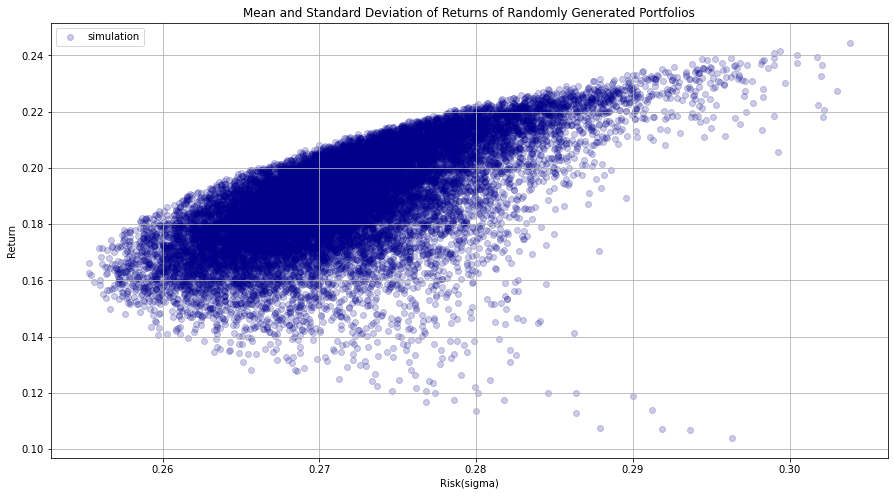

In [99]:
regression_return = regression_df[["UBS","JPM","GS","MS","BAC"]]
regression_return  # --> Asset Return DataFrame 



cov  = regression_return.cov() * 252   # construct cov matrix through returns (annualized)
mean = regression_return.mean()  * 252 # construct mean return (annualized)


trial_numbers = 20000
all_weights   = np.zeros((trial_numbers,mean.shape[0]))
all_risk      = np.zeros((trial_numbers))
all_returns   = np.zeros((trial_numbers))

for i in range(trial_numbers):

    # Random Uniform Generate Weights
    weights        = np.random.uniform(size=mean.shape[0])
    weights        = weights/np.sum(weights)
    all_weights[i] = weights
    
    # portfolio varience/risk
    portfolio_varience = np.dot(np.dot(weights.transpose(),cov),weights)
    risk               = np.sqrt(portfolio_varience)
    all_risk[i]        = risk

    # portfolio return
    portfolio_return   = np.dot(weights.transpose(),mean) 
    all_returns[i]     = portfolio_return

    
fig,ax = plt.subplots(figsize=(15,8))
ax.set_title("Mean and Standard Deviation of Returns of Randomly Generated Portfolios")
ax.scatter(all_risk,all_returns,marker="o",alpha=0.2,color='darkblue',label="simulation")
ax.set_xlabel("Risk(sigma)")
ax.set_ylabel("Return")
ax.legend()
plt.grid()
plt.show()

# Use Markowitz portfolio theory & Maximize Sharp Ratio to locat Optimal Portfolio weights

In [100]:
from scipy.optimize import minimize

class Markowitz_Portfolio_Optimization():

    def __init__(self,returns,u):

        ## setting expected portfolio return and the tolerate portfolio variance
        self.initial_weight = np.ones((returns.shape[1],1))

        self.bounds = [(0,1000),(0,1000),(0,1000),(0,1000),(0,1000)] # can't short stock
        self.mean   = returns.mean() * 252
        self.cov    = returns.cov()  * 252
        self. u     = u

    def objective_function(self,w) :  # portfolio varience --> minimize
        w_tp=w.transpose()
        return np.dot(np.dot(w_tp,self.cov),w)

    def equality_constraint_1(self,w) : # weight sum = 1
        w_tp=w.transpose()
        return 1-np.dot(w_tp,self.initial_weight)

    def equality_constraint_2(self,w): # given certain return
        w_tp=w.transpose()
        return self.u-np.dot(w_tp,self.mean)

        
    def optimization(self):

        constraint_1 = {'type': 'eq','fun':  self.equality_constraint_1} # weight sum = 1
        constraint_2 = {'type': 'eq','fun':  self.equality_constraint_2} # given certain return
        constraint   = [constraint_1,constraint_2]

        result=minimize(self.objective_function,self.initial_weight,method='SLSQP',bounds=self.bounds,constraints=constraint)
        self.final_weight = result['x']

        return result['x']
        
    def print_result(self):

        for i in range(len(self.final_weight)):
            print('weights'+ str(i+1) + ': ',"{:.19f}".format(float(self.final_weight[i])))

        return self.final_weight
    
    def optimal_portfolio(self):

        optimal_portfolio_risk     = np.sqrt(np.dot(np.dot(self.final_weight.transpose(),self.cov),self.final_weight))
        optimal_portfolio_returns  = np.dot(self.final_weight.transpose(),self.mean)

        return optimal_portfolio_risk , optimal_portfolio_returns


model = Markowitz_Portfolio_Optimization(returns=regression_return,u=0.16)
w = model.optimization()
w = model.print_result()
optimal_portfolio_risk , optimal_portfolio_returns = model.optimal_portfolio()


weights1:  0.2608928406106419962
weights2:  0.4710473641561781499
weights3:  0.2680597952331797429
weights4:  0.0000000000000000304
weights5:  0.0000000000000000192


In [101]:
class Sharpe_Ratio_Portfolio_Optimization():

    def __init__(self,returns,risk_free_rate):

        self.initial_weight = np.ones((returns.shape[1],1)) ## setting expected portfolio return and the tolerate portfolio variance

        self.bounds = [(0,1),(0,1),(0,1),(0,1),(0,1)] # can't short stock
        self.mean   = returns.mean() * 252
        self.cov    = returns.cov()  * 252
        self.rf     = risk_free_rate
    
    def objective_function(self,w) :  # portfolio Shrape Ratio --> maximize

        w_tp = w.transpose()

        portfolio_risk = np.dot(np.dot(w_tp,self.cov),w)
        Shrape_Ratio   = (np.dot(w_tp,self.mean) - self.rf) / portfolio_risk

        return -Shrape_Ratio 

    def equality_constraint_1(self,w) : # weight sum = 1
        w_tp=w.transpose()
        return 1-np.dot(w_tp,self.initial_weight)

        
    def optimization(self):

        constraint_1 = {'type': 'eq','fun':  self.equality_constraint_1} # weight sum = 1
        constraint   = [constraint_1]

        result=minimize(self.objective_function,self.initial_weight,method='SLSQP',bounds=self.bounds,constraints=constraint)
        self.final_weight = result['x']

        return result['x']
        
    def print_result(self):

        for i in range(len(self.final_weight)):
            print('weights'+ str(i+1) + ': ',"{:.19f}".format(float(self.final_weight[i])))

        return self.final_weight
    
    def optimal_portfolio(self):

        optimal_portfolio_risk     = np.sqrt(np.dot(np.dot(self.final_weight.transpose(),self.cov),self.final_weight))
        optimal_portfolio_returns  = np.dot(self.final_weight.transpose(),self.mean)

        return optimal_portfolio_risk , optimal_portfolio_returns


model = Sharpe_Ratio_Portfolio_Optimization(returns=regression_return,risk_free_rate=current_RF)
sharpe_ratio_w = model.optimization()
sharpe_ratio_w = model.print_result()
SR_optimal_portfolio_risk , SR_optimal_portfolio_returns = model.optimal_portfolio()

weights1:  0.0000000000000000000
weights2:  0.4548394470448979821
weights3:  0.2119902523079787160
weights4:  0.0494194234094439966
weights5:  0.2837508772376793886


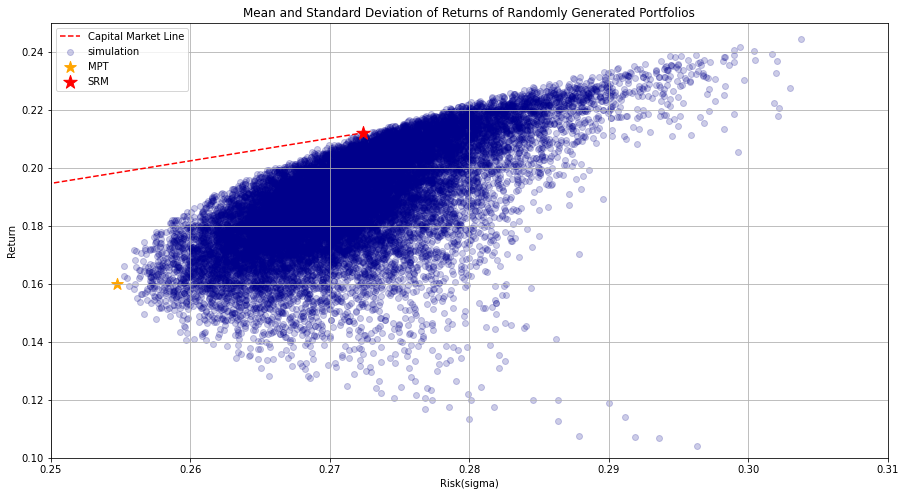

In [102]:
x = np.linspace(current_RF,SR_optimal_portfolio_risk,200)
y = np.linspace(current_RF,SR_optimal_portfolio_returns,200)


fig,ax = plt.subplots(figsize=(15,8))
ax.set_title("Mean and Standard Deviation of Returns of Randomly Generated Portfolios")
ax.scatter(all_risk,all_returns,marker="o",alpha=0.2,color='darkblue',label="simulation")
ax.scatter(optimal_portfolio_risk,optimal_portfolio_returns,color='orange',marker="*",s=150,label='MPT')
ax.scatter(SR_optimal_portfolio_risk,SR_optimal_portfolio_returns,color='red',marker='*',s=200,label='SRM')
ax.plot(x,y,color='red',label='Capital Market Line',linestyle='--')

ax.set_xlabel("Risk(sigma)")
ax.set_ylabel("Return")
ax.set_xlim(0.25,0.31)
ax.set_ylim(0.1,0.25)
ax.legend()
plt.grid()
plt.show()